In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


In [2]:
#import training dataset

dataset = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/grand_salon_20_01_b/torch_dataset_all.pkl')

print(dataset)
# print(len(dataset))

cmd_left_str_list = []
cmd_right_str_list = []
for i in range(0, 40):
    str_cmd_left_i = 'cmd_left_' + str(i)
    str_cmd_right_i = 'cmd_right_' + str(i)
    cmd_left_str_list.append(str_cmd_left_i)
    cmd_right_str_list.append(str_cmd_right_i)
cmd_left_vels_array = dataset[cmd_left_str_list].to_numpy()
cmd_right_vels_array = dataset[cmd_right_str_list].to_numpy()
print(cmd_left_vels_array)

encoder_left_str_list = []
encoder_right_str_list = []
for i in range(0, 40):
    str_encoder_left_i = 'left_wheel_vel_' + str(i)
    str_encoder_right_i = 'right_wheel_vel_' + str(i)
    encoder_left_str_list.append(str_encoder_left_i)
    encoder_right_str_list.append(str_encoder_right_i)
encoder_left_vels_array = dataset[encoder_left_str_list].to_numpy()
encoder_right_vels_array = dataset[encoder_right_str_list].to_numpy()

# import input space info
input_space_dataframe = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/input_space/input_space_data.pkl')
ideal_diff_drive = Ideal_diff_drive(input_space_dataframe['calibrated_radius [m]'].to_numpy()[0], input_space_dataframe['calibrated baseline [m]'].to_numpy()[0], 0.05)

# print(input_space_dataframe)



     init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0           0.0         0.0         0.0            0.0             0.0   
1           0.0         0.0         0.0            0.0             0.0   
2           0.0         0.0         0.0            0.0             0.0   
3           0.0         0.0         0.0            0.0             0.0   
4           0.0         0.0         0.0            0.0             0.0   
..          ...         ...         ...            ...             ...   
628         0.0         0.0         0.0            0.0             0.0   
629         0.0         0.0         0.0            0.0             0.0   
630         0.0         0.0         0.0            0.0             0.0   
631         0.0         0.0         0.0            0.0             0.0   
632         0.0         0.0         0.0            0.0             0.0   

     init_icp_yaw  calib_step  cmd_left_0  cmd_right_0  cmd_left_1  ...  \
0             0.0         0.0    0.0

In [3]:
# find biggest dynamic window

n_windows = len(dataset)
max_left_diff_window = 0
last_max_left_vel_diff = 0

for i in range(0, n_windows):
    left_vel_diff = np.abs(cmd_left_vels_array[i, 0] - cmd_left_vels_array[i, 39])
    if left_vel_diff > last_max_left_vel_diff:
        max_left_diff_window = i
        last_max_left_vel_diff = left_vel_diff
        
print(n_windows)
print(max_left_diff_window)

633
189


1.0


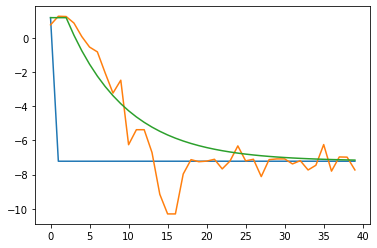

In [23]:
# import powertrain model
time_constant = 0.40823536
time_delay = 0.05945159
dt = 0.05
bounded_powertrain = Bounded_powertrain(-10, 10, time_constant, time_delay, dt)

# analyse bounded powertrain performance
analysis_window = 315

cmd_left_vels = cmd_left_vels_array[analysis_window, :]
encoder_left_vels = encoder_left_vels_array[analysis_window, :]

predicted_left_wheel_vels = np.zeros(40)
predicted_left_wheel_vels[0] = cmd_left_vels[0]

cmd_elapsed_time = 0

for i in range(1, 40):
    predicted_left_wheel_vels[i] = bounded_powertrain.compute_bounded_wheel_vels(cmd_left_vels[i], predicted_left_wheel_vels[i-1], cmd_elapsed_time)
    cmd_elapsed_time += dt
    

print(dataset['transitory_state_mask'][analysis_window])

plt.plot(cmd_left_vels)
plt.plot(encoder_left_vels)
plt.plot(predicted_left_wheel_vels)

In [12]:
# plot left wheel vel

dt = 0.05
timestamps_per_horizon = 40
start_id = 238
end_id = 240
num_timestamps = int((end_id - start_id) * 40)
print(num_timestamps)
print(end_id * 40 - start_id * 40)

time_vector = np.linspace(0, num_timestamps, num_timestamps)

window_start = 2*timestamps_per_horizon+2
steady_state_limits = np.array([window_start, window_start + 30])

plt.plot(time_vector, cmd_vel_left_flat[start_id*40:end_id*40], label='command')
plt.plot(time_vector, encoder_vel_left_flat[start_id*40:end_id*40], label='encoder')
plt.plot(time_vector, transitory_vel_left_flat[start_id*40:end_id*40], label='encoder')
# plt.vlines(steady_state_limits, -12, 12, color='C7', label='transitory-state (~1.5 s)')

plt.xlabel('timestamp')
plt.ylabel('left wheel vel [rad/s]')

plt.legend()

80
80


NameError: name 'cmd_vel_left_flat' is not defined